In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Carregue o DataFrame a partir do arquivo Parquet
df_train = pd.read_parquet('/home/moas/GembaGuard/data/df_train.parquet')

In [3]:
df_train.head(5)

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


In [4]:
## **Observando e tratando as inconsistências**

In [5]:
# Renomear as colunas corretamente
df_train = df_train.rename(columns={
    'FDF (Falha Desgaste Ferramenta)': 'FDF',
    'FDC (Falha Dissipacao Calor)': 'FDC',
    'FP (Falha Potencia)': 'FP',
    'FTE (Falha Tensao Excessiva)': 'FTE',
    'FA (Falha Aleatoria)': 'FA'
})


In [6]:
# # Dicionario para mapear todas as variações para 0 ou 1 e padronizar as colunas de falha
failure_cols = [
    'FDF', 'FDC',
    'FP', 'FTE',
    'FA', 'falha_maquina'
]
mapeamento_valores = {
    'Sim': 1, 'sim': 1, 'S': 1, 'True': 1, 'y': 1, '1': 1, 1: 1,
    'Não': 0, 'não': 0, 'nao': 0, 'N': 0, 'False': 0, '0': 0, 0: 0
}

for col in failure_cols:
    df_train[col] = df_train[col].astype(str).map(mapeamento_valores).fillna(0).astype(int)
    print   (f"{col}: {df_train[col].unique()}")


FDF: [0 1]
FDC: [0 1]
FP: [0 1]
FTE: [0 1]
FA: [0 1]
falha_maquina: [0 1]


In [7]:
# Remover linhas duplicadas do DataFrame
df_train = df_train.drop_duplicates()

In [8]:
# Remover o prefixo 'L' ou 'M' da coluna 'id_produto', pois essa informação já está presente na coluna 'tipo'
df_train['id_produto'] = df_train['id_produto'].str[1:]

In [9]:
df_train.head(15)

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
0,0,56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,0,0,0,0,0,0
1,1,48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,0,0,0,0,0,0
2,2,48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,0,0,0,0,0,0
3,3,20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,0,0,0,0,0,0
4,4,53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,0,0,0,0,0,0
5,5,53113,L,300.5,310.5,90.0,-161.0,47.4,56.0,0,0,0,0,0,0
6,6,23689,M,-36.0,308.8,90.0,1469.0,44.1,150.0,0,0,0,0,0,0
7,7,55125,L,300.8,311.7,90.0,1655.0,32.2,12.0,0,0,0,0,0,0
8,8,50688,L,301.7,310.9,90.0,1608.0,33.0,-202.0,0,0,0,0,0,0
9,9,49182,L,298.5,308.2,90.0,1654.0,27.1,13.0,0,0,0,0,0,0


In [10]:
#Identificando as colunas numéricas e categóricas para depois aplicar transformações específicas
colunas_numericas = []
colunas_categoricas = []

for coluna in df_train.columns:
    if df_train[coluna].dtype in ['float64', 'int64']:
        colunas_numericas.append(coluna)
    elif df_train[coluna].dtype == 'object':
        colunas_categoricas.append(coluna)
print("Colunas Numéricas:", colunas_numericas)
print("Colunas Categóricas:", colunas_categoricas)

Colunas Numéricas: ['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF', 'FDC', 'FP', 'FTE', 'FA']
Colunas Categóricas: ['id_produto', 'tipo']


In [11]:
#Inserindo dos valores faltantes nas colunas numéricas
for coluna in colunas_numericas:
    media = df_train[coluna].mean()
    df_train[coluna] = df_train[coluna].fillna(media)

In [12]:
#Inserindo dos valores faltantes nas colunas categóricas
for coluna in colunas_categoricas:
    valor_mais_frequente = df_train[coluna].mode()[0]
    df_train[coluna] = df_train[coluna].fillna(valor_mais_frequente)

In [13]:
#Havia tratao a coluna id_produto, mas revi que ela não será relevante para a modelagem
df_train = df_train.drop(columns=['id', 'id_produto'])

In [14]:
#Confirmando se a coluna id foi removida do nosso dataset 
df_train.head(5)

,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
0,L,298.3,309.1,90.0,1616.0,31.1,195.000000,0,0,0,0,0,0
1,L,298.2,308.4,90.0,1388.0,53.8,137.000000,0,0,0,0,0,0
2,L,298.2,307.8,90.0,1528.0,31.1,74.373266,0,0,0,0,0,0
3,M,300.9,310.8,90.0,1599.0,33.0,7.000000,0,0,0,0,0,0
4,L,-36.0,310.5,90.0,1571.0,33.9,74.373266,0,0,0,0,0,0


In [15]:
#Assumi que a coluna 'tipo' se refere ao tamanho do produto, decidi usar a codificação ordinal
mapeamento_ordinal = {'L': 0, 'M': 1, 'H': 2}
df_train['tipo'] = df_train['tipo'].map(mapeamento_ordinal)

In [16]:
(df_train['temperatura_ar'] < 0).sum()

np.int64(3132)

In [17]:
#Havia notado que a coluna temperatura_ar tinha valores negativos, apesar de ser uma possibilidade em regiões mais frias, vamos assumir 
# que não é o nosso caso e substituir pela mediana 
mediana_temp_ar_valida = df_train.loc[df_train['temperatura_ar'] >= 0, 'temperatura_ar'].median()
df_train.loc[df_train['temperatura_ar'] < 0, 'temperatura_ar'] = mediana_temp_ar_valida

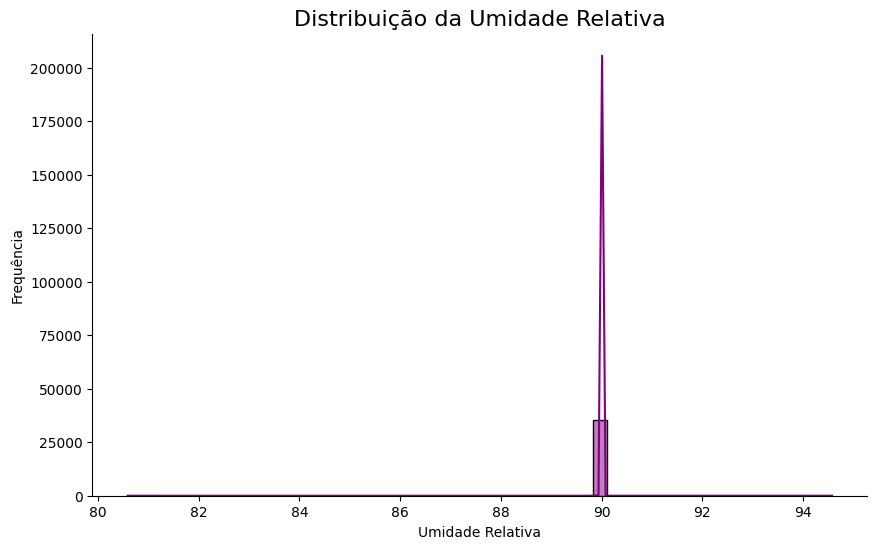

In [18]:
#Analisando a nossa coluna de umidade_relativa que havíamos visto que tinha valores constantes
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df_train['umidade_relativa'], bins=50, kde=True, color='purple')
plt.title('Distribuição da Umidade Relativa', fontsize=16)
plt.xlabel('Umidade Relativa')
plt.ylabel('Frequência')
sns.despine()
plt.show()

In [19]:
#Removendo as colunas umidade_relativa, pois não traz valor ao modelo
df_train = df_train.drop(columns=['umidade_relativa'])

In [20]:
df_train.head(20)

,tipo,temperatura_ar,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
0,0,298.300000,309.1,1616.000000,31.1,195.000000,0,0,0,0,0,0
1,0,298.200000,308.4,1388.000000,53.8,137.000000,0,0,0,0,0,0
2,0,298.200000,307.8,1528.000000,31.1,74.373266,0,0,0,0,0,0
3,1,300.900000,310.8,1599.000000,33.0,7.000000,0,0,0,0,0,0
4,0,300.000000,310.5,1571.000000,33.9,74.373266,0,0,0,0,0,0
5,0,300.500000,310.5,-161.000000,47.4,56.000000,0,0,0,0,0,0
6,1,300.000000,308.8,1469.000000,44.1,150.000000,0,0,0,0,0,0
7,0,300.800000,311.7,1655.000000,32.2,12.000000,0,0,0,0,0,0
8,0,301.700000,310.9,1608.000000,33.0,-202.000000,0,0,0,0,0,0
9,0,298.500000,308.2,1654.000000,27.1,13.000000,0,0,0,0,0,0


In [21]:
#Tratando valores incomuns na coluna desgaste_da_ferramenta
(df_train['desgaste_da_ferramenta'] < 0).sum()

np.int64(3439)

In [22]:
# Exibe as primeiras 10 linhas onde o desgaste é -202
df_train[df_train['desgaste_da_ferramenta'] == -202].head(20)

,tipo,temperatura_ar,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
8,0,301.7,310.900000,1608.000000,33.000000,-202.0,0,0,0,0,0,0
16,0,299.9,311.300000,1535.000000,38.100000,-202.0,0,0,0,0,0,0
25,0,298.4,309.200000,1610.000000,32.400000,-202.0,0,0,0,0,0,0
34,1,303.1,311.400000,1831.000000,40.210357,-202.0,0,0,0,0,0,0
56,1,300.0,310.200000,1380.194181,51.200000,-202.0,0,0,0,0,0,0
66,1,298.8,310.100000,1585.000000,40.210357,-202.0,0,0,0,0,0,0
85,1,298.7,309.900000,2083.000000,18.200000,-202.0,0,0,0,0,0,0
88,0,298.9,280.457676,1467.000000,44.700000,-202.0,0,0,0,0,0,0
99,0,301.5,310.700000,1686.000000,27.900000,-202.0,0,0,0,0,0,0
109,1,299.2,308.500000,1526.000000,37.300000,-202.0,0,0,0,0,0,0


In [23]:
# A coluna desgaste da ferramenta chama a atenção por não estar relacionada a nenhuma falha. Vamos analisar mais profundamente
# Vamos analisar as linhas onde o desgaste NÃO É -202
df_desgaste_valido = df_train[df_train['desgaste_da_ferramenta'] != -202]
print("Contagem de 'falha_maquina' para dados com desgaste válido:")
print(df_desgaste_valido['falha_maquina'].value_counts())

Contagem de 'falha_maquina' para dados com desgaste válido:
falha_maquina
0    31234
1      587
Name: count, dtype: int64


In [24]:
# Contar a ocorrência de cada tipo de falha específica nessas linhas
df_falha_desgaste_valido = df_train[(df_train['desgaste_da_ferramenta'] != -202) & (df_train['falha_maquina'] == 1)]
falhas_desgaste_valido_contagem = df_falha_desgaste_valido[failure_cols[:-1]].sum()
print(falhas_desgaste_valido_contagem)

FDF     68
FDC    192
FP     118
FTE    145
FA       2
dtype: int64


In [25]:
# Também havíamos notado no EDA que desgaste da ferramenta continha valores 0 vamos entender melhor o que são esses valores.
tabela_zeros = pd.crosstab(df_train['desgaste_da_ferramenta'] == 0, df_train['falha_maquina'])
print("Relação entre Desgaste Zero e Falha de Máquina:")
print(tabela_zeros)

Relação entre Desgaste Zero e Falha de Máquina:
falha_maquina               0    1
desgaste_da_ferramenta            
False                   33850  652
True                      748   10


Parece que mesmo a falha de máquina ocorrendo, o desgaste da ferramenta é 0, então esses valores são reais. No grupo de máquinas onde o desgaste da ferramenta NÃO é zero:Houve 34.598 casos de operação normal (sem falha). 662 casos de falha de máquina. Assim, optamos por manter os zeros nessa variável.

In [26]:
# A coluna velocidade_rotacional também apresentou valores negativos, o que não faz sentido fisicamente.
#  Vamos analisar esses valores e ver as linhas onde 'velocidade_rotacional' é negativa
df_train[df_train['velocidade_rotacional'] <=0]

,tipo,temperatura_ar,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
5,0,300.5,310.5,-161.0,47.4,56.0,0,0,0,0,0,0
27,1,303.5,312.9,-161.0,30.4,130.0,0,0,0,0,0,0
35,1,300.1,309.5,-161.0,42.8,50.0,0,0,0,0,0,0
36,0,298.5,309.3,-161.0,33.1,109.0,0,0,0,0,0,0
43,1,300.4,310.4,-161.0,36.3,21.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35212,2,300.0,311.3,-161.0,39.6,51.0,0,0,0,0,0,0
35219,0,300.3,311.1,-161.0,47.2,156.0,0,0,0,0,0,0
35229,0,302.6,310.4,-161.0,36.1,-202.0,0,0,0,0,0,0
35235,0,297.4,308.6,-161.0,34.9,83.0,0,0,0,0,0,0


In [27]:
# Substituir valores negativos de 'velocidade_rotacional' pela mediana dos valores válidos
mediana_velocidade = df_train.loc[df_train['velocidade_rotacional'] >= 0, 'velocidade_rotacional'].median()
df_train.loc[df_train['velocidade_rotacional'] < 0, 'velocidade_rotacional'] = mediana_velocidade

In [28]:
#Vamos tratar os missing values  para seguirmos com a nossa preparação dos dados
df_train['temperatura_ar'].fillna(df_train['temperatura_ar'].median(), inplace=True)
df_train['temperatura_processo'].fillna(df_train['temperatura_processo'].median(), inplace=True)
df_train['velocidade_rotacional'].fillna(df_train['velocidade_rotacional'].median(), inplace=True)
df_train['desgaste_da_ferramenta'].fillna(df_train['desgaste_da_ferramenta'].median(), inplace=True)

/tmp/ipykernel_437550/1546955135.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['temperatura_ar'].fillna(df_train['temperatura_ar'].median(), inplace=True)
/tmp/ipykernel_437550/1546955135.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

Como nossos dados são desbalanceados e o problema indica a necessidade de aferir não apenas se houve falha, mas também dizer qual o tipo de falha, achei importante considerar um olhar mais refinado para a relação de desgaste da ferramenta associado as falhas.

In [29]:
# Vamos criar uma nova coluna para capturar o desgaste medido. Se a medição falhou (< 0) e 1 se foi bem-sucedida (>= 0).
df_train['desgaste_medido'] = np.where(df_train['desgaste_da_ferramenta'] < 0, 0, 1)
df_train.loc[df_train['desgaste_da_ferramenta'] < 0, 'desgaste_da_ferramenta'] = np.nan
mediana_desgaste = df_train['desgaste_da_ferramenta'].median()
df_train['desgaste_da_ferramenta'].fillna(mediana_desgaste, inplace=True)

/tmp/ipykernel_437550/306191670.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['desgaste_da_ferramenta'].fillna(mediana_desgaste, inplace=True)


In [30]:
#Conferindo as minhas colunas
df_train.columns

Index(['tipo', 'temperatura_ar', 'temperatura_processo',
       'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta',
       'falha_maquina', 'FDF', 'FDC', 'FP', 'FTE', 'FA', 'desgaste_medido'],
      dtype='object')

In [31]:
df_train.head(10)

,tipo,temperatura_ar,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA,desgaste_medido
0,0,298.3,309.1,1616.0,31.1,195.000000,0,0,0,0,0,0,1
1,0,298.2,308.4,1388.0,53.8,137.000000,0,0,0,0,0,0,1
2,0,298.2,307.8,1528.0,31.1,74.373266,0,0,0,0,0,0,1
3,1,300.9,310.8,1599.0,33.0,7.000000,0,0,0,0,0,0,1
4,0,300.0,310.5,1571.0,33.9,74.373266,0,0,0,0,0,0,1
5,0,300.5,310.5,1492.0,47.4,56.000000,0,0,0,0,0,0,1
6,1,300.0,308.8,1469.0,44.1,150.000000,0,0,0,0,0,0,1
7,0,300.8,311.7,1655.0,32.2,12.000000,0,0,0,0,0,0,1
8,0,301.7,310.9,1608.0,33.0,104.000000,0,0,0,0,0,0,0
9,0,298.5,308.2,1654.0,27.1,13.000000,0,0,0,0,0,0,1


In [32]:
print("Colunas Numéricas:", colunas_numericas)
print("Colunas Categóricas:", colunas_categoricas)

Colunas Numéricas: ['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF', 'FDC', 'FP', 'FTE', 'FA']
Colunas Categóricas: ['id_produto', 'tipo']


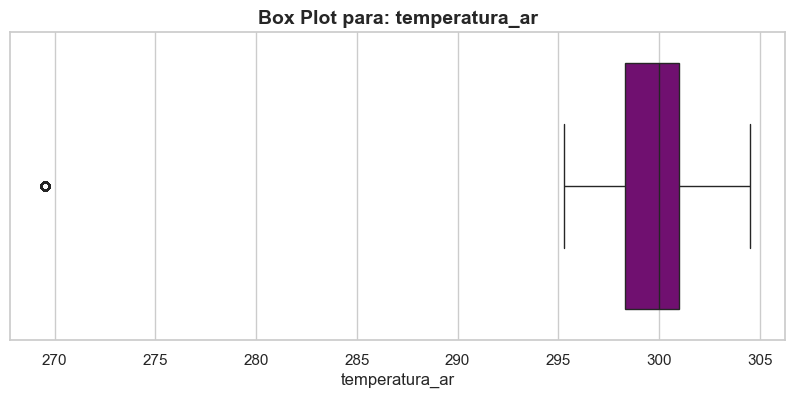

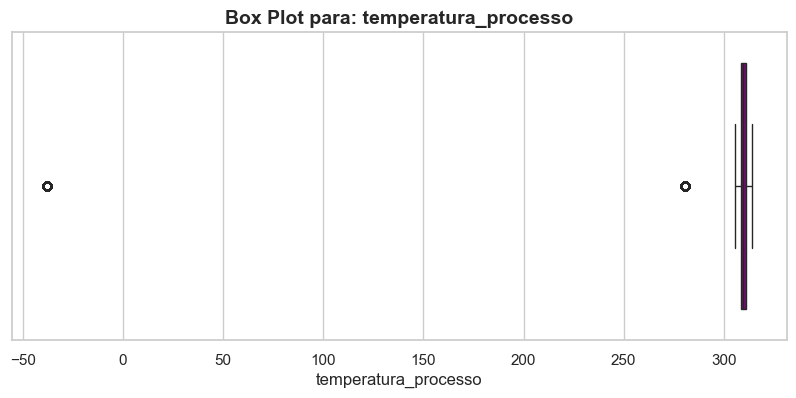

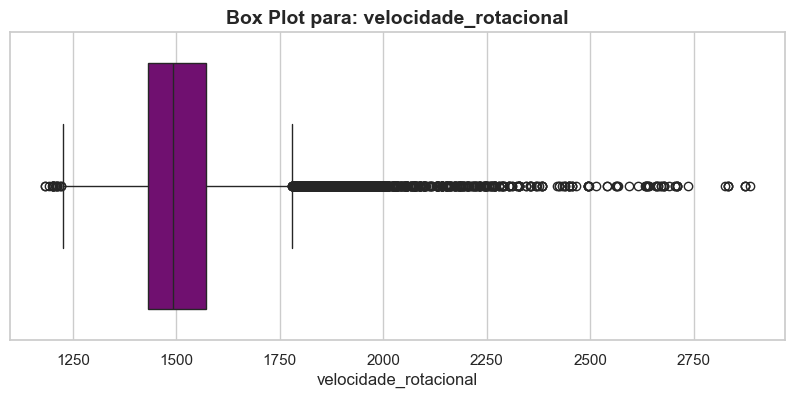

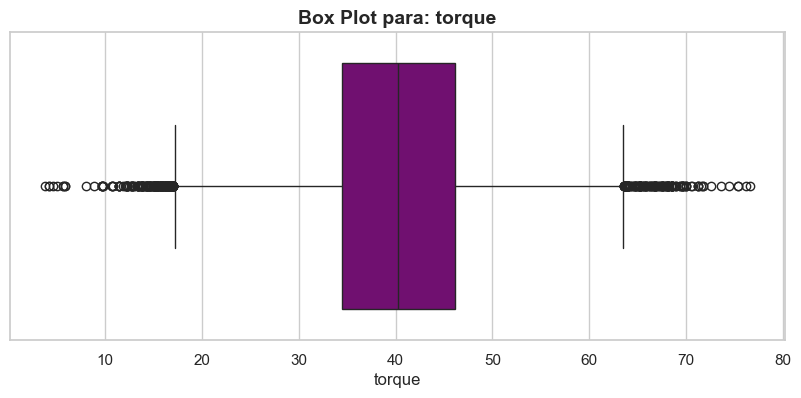

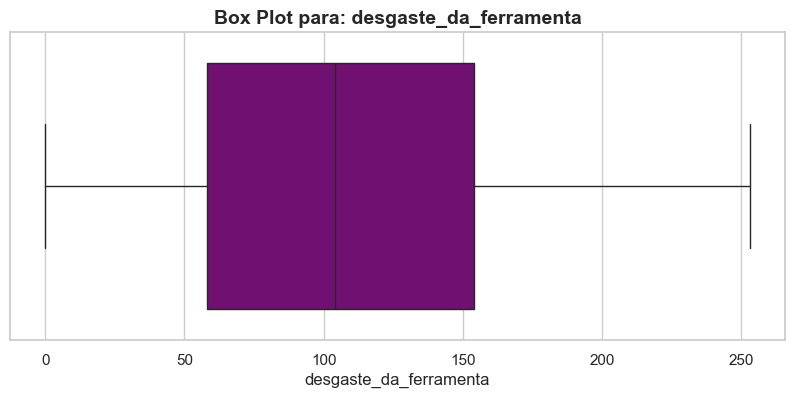

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colunas_numericas = [
    'temperatura_ar', 
    'temperatura_processo', 
    'velocidade_rotacional', 
    'torque', 
    'desgaste_da_ferramenta'
]
for coluna in colunas_numericas:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_train[coluna], color='purple')
    plt.title(f'Box Plot para: {coluna}', fontsize=14, weight='bold')
    plt.xlabel(coluna, fontsize=12)
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

# --- A SOLUÇÃO: Definir a lista correta IMEDIATAMENTE ANTES do loop ---
colunas_numericas = [
    'temperatura_ar', 
    'temperatura_processo', 
    'velocidade_rotacional', 
    'torque', 
    'desgaste_da_ferramenta'
]
for coluna in colunas_numericas:
    # Calcular a Mediana, Q1 e Q3
    mediana = df_train[coluna].median()
    Q1 = df_train[coluna].quantile(0.25)
    Q3 = df_train[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df_train[(df_train[coluna] < limite_inferior) | (df_train[coluna] > limite_superior)]
    num_outliers = len(outliers)
    
    percentual_outliers = (num_outliers / len(df_train)) * 100
    
    print(f"Análise para a coluna: '{coluna}'")
    print(f"  - Mediana (Q2): {mediana:.2f}")
    print(f"  - Primeiro Quartil (Q1): {Q1:.2f}")
    print(f"  - Terceiro Quartil (Q3): {Q3:.2f}")
    print(f"  - Número de Outliers Encontrados: {num_outliers} ({percentual_outliers:.2f}%)")
    print("-" * 60)

Análise para a coluna: 'temperatura_ar'
  - Mediana (Q2): 300.00
  - Primeiro Quartil (Q1): 298.50
  - Terceiro Quartil (Q3): 301.00
  - Número de Outliers Encontrados: 0 (0.00%)
------------------------------
Análise para a coluna: 'temperatura_processo'
  - Mediana (Q2): 309.70
  - Primeiro Quartil (Q1): 308.50
  - Terceiro Quartil (Q3): 310.90
  - Número de Outliers Encontrados: 0 (0.00%)
------------------------------
Análise para a coluna: 'velocidade_rotacional'
  - Mediana (Q2): 1492.00
  - Primeiro Quartil (Q1): 1432.00
  - Terceiro Quartil (Q3): 1571.00
  - Número de Outliers Encontrados: 0 (0.00%)
------------------------------
Análise para a coluna: 'torque'
  - Mediana (Q2): 40.21
  - Primeiro Quartil (Q1): 34.50
  - Terceiro Quartil (Q3): 46.10
  - Número de Outliers Encontrados: 371 (1.05%)
------------------------------
Análise para a coluna: 'desgaste_da_ferramenta'
  - Mediana (Q2): 104.00
  - Primeiro Quartil (Q1): 58.00
  - Terceiro Quartil (Q3): 154.00
  - Número de

#**Tratando os outliers**

In [ ]:
#Notamos outliers em quase todas as colunas numéricas, torque, temperatura_ar, temperatura_processo e 
# velocidade rotacional, com exceção da coluna torque vamos tratar os demais.
#Tratando a coluna temperatura_ar
# Definimos os limites e a mediana especificamente para 'temperatura_ar'
Q1 = df_train['temperatura_ar'].quantile(0.25)
Q3 = df_train['temperatura_ar'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
mediana = df_train['temperatura_ar'].median()

df_train.loc[
    (df_train['temperatura_ar'] < limite_inferior) | (df_train['temperatura_ar'] > limite_superior), 'temperatura_ar'] = mediana

In [ ]:
#A coluna velocidade_rotacional e temperatura_processo, vou tratar com a 
# técnica de limitar os extremos (capping)
coluna = 'temperatura_processo'
Q1 = df_train[coluna].quantile(0.25)
Q3 = df_train[coluna].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_train[coluna] = df_train[coluna].clip(lower=limite_inferior, upper=limite_superior)
print(f"Outliers de '{coluna}' foram definidos entre {limite_inferior:.2f} e {limite_superior:.2f}.")

--> Outliers de 'temperatura_processo' foram 'capados' entre 304.90 e 314.50.


In [45]:
#A coluna velocidade_rotacional e temperatura_processo, vou tratar com a 
# técnica de limitar os extremos (capping)
coluna = 'velocidade_rotacional'
Q1 = df_train[coluna].quantile(0.25)
Q3 = df_train[coluna].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_train[coluna] = df_train[coluna].clip(lower=limite_inferior, upper=limite_superior)
print(f"Outliers de '{coluna}' foram 'definidos' entre {limite_inferior:.2f} e {limite_superior:.2f}.")

Outliers de 'velocidade_rotacional' foram 'definidos' entre 1223.50 e 1779.50.


#**Considerações sobre o tratamento das inconsistências**


- Remoção da Coluna id_produto: Removemos esta coluna pois se trata de um identificador único, não possuindo valor preditivo ou correlação com as falhas da máquina.

- Remoção da Coluna umidade_relativa: A coluna foi removida pois a análise revelou que seus valores eram quase constantes (extrema assimetria), indicando uma provável falha de sensor ou um valor fixo, o que a torna inútil para a modelagem.

- Codificação Ordinal da Coluna tipo: Mapeamos as categorias 'L', 'M' e 'H' para os valores numéricos 0, 1 e 2. Esta abordagem foi escolhida para preservar a relação intrínseca de ordem (ex: tamanho do produto), que é uma informação valiosa para o modelo.

- Engenharia de Features para desgaste_da_ferramenta: Criamos a variável binária desgaste_medido (0 ou 1) pois a investigação mostrou que os valores negativos (-202) não eram erros aleatórios, mas sim um código de estado que indicava quando a medição de desgaste não era realizada, uma informação fortemente correlacionada ao estado de falha.

- Tratamento de Valores Impossíveis (Negativos): Substituímos os valores negativos nas colunas de temperatura e velocidade_rotacional pela mediana de suas respectivas colunas, pois são leituras fisicamente impossíveis que representam erros de medição.

-Escolha da Mediana sobre a Média: Em todos os casos de imputação (preenchimento de dados faltantes ou errados), optamos por usar a mediana em vez da média. Fizemos essa escolha porque a mediana é uma medida de tendência central robusta e não é afetada por valores extremos (outliers), garantindo que nossas imputações representem o valor "típico" do processo sem serem distorcidas por leituras anormais.

- Manutenção dos Zeros em desgaste_da_ferramenta: Decidimos manter os valores 0 nesta coluna, pois a análise mostrou que eles estão associados a uma taxa de falha quase nula, representando um estado válido (provavelmente de uma ferramenta nova).

- Imputação de Valores Ausentes (NaN): Preenchemos todos os valores ausentes (NaN) nas colunas numéricas com a mediana de suas respectivas colunas. A mediana foi escolhida em detrimento da média por sua robustez e baixa sensibilidade a outliers.

- Manutenção dos Outliers em torque: Decidimos manter os outliers nesta coluna, pois representam uma porcentagem muito pequena dos dados (≈1%) e provavelmente indicam condições operacionais reais e informativas (ex: picos de esforço) que são sinais valiosos para o modelo.

- Tratamento de Outliers com Capping (Limitação): Aplicamos a técnica de capping nas colunas temperatura_processo e velocidade_rotacional. Fizemos isso pois, embora seus outliers pudessem ser eventos reais, a alta quantidade (10% e 5%, respectivamente) poderia influenciar o modelo de forma desproporcional. O capping limita essa influência sem descartar a informação contida no resto da linha.

## **Analisando nossas falhas**